
# Welcome to Heat Signature Zero 🔥❄️

Step into the fascinating world of thermal dynamics! In this challenge, you’ll work with distributed temperature time-series data collected from a 2D Thermal Plate subjected to unknown heat sources. Your mission: **reverse-engineer the hidden heat sources (their locations and intensities) that best explain the observed thermal patterns.**

Imagine yourself as a thermal detective, piecing together clues from sensor data to uncover the invisible forces shaping the plate’s behavior. But here’s the twist: we’re not looking for brute-force grid searches or massive end-to-end ML models that memorize every possible scenario. Instead, we want smart, adaptive approaches that leverage the provided thermal simulation engine as an active partner during inference. Your solution should iteratively refine source parameters using simulation feedback, moving toward optimal solutions efficiently and intelligently.

And here’s why this matters: while the challenge is themed around heat diffusion, the techniques you develop here can go far beyond thermal systems. This problem is a proxy for a broader class of simulation-driven parameter optimization tasks. These tasks are critical in domains like aerospace engineering, climate modeling, robotics, material science, and energy systems. The goal is to pioneer methods that can generalize to any scenario where simulation engines guide decision-making.

So, are you ready to decode the heat signature and shape the future of intelligent parameter optimization? Let’s dive in and start uncovering the secrets behind Heat Signature Zero! 🔍🔥


### Supplied Materials

To help you get started, we’ve provided the following resources:

- **Starter Notebook**  
  Your main entry point for exploring the challenge, understanding the workflow, and building your solution.

- **`simulator.py`**  
  Contains the `Heat2D` class—the simulation engine that solves the heat diffusion problem. This is your key tool for generating synthetic data and refining parameter estimates during inference.

- **Test Dataset**  
  A pickled file, `testdata_80samples.pkl`, with temperature sensor readings and related simulation metadata for **80 samples**. You will submit your predicted source parameters for these samples to generate your leaderboard score.

- **`utils.py`**  
  Includes helper functions used in the starter notebook to simplify common tasks and accelerate your development process.

- **`requirements.txt`**  
  Lists all the required Python packages for your solution. Make sure your submission includes this file so your environment can be easily reproduced.


# Imports
REMEMBER TO ADD YOUR PACKAGES TO the requirements.txt

In [1]:
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Circle

from simulator import Heat2D
from utils import *


## 🔥 Heat Diffusion Simulation Setup

This challenge revolves around simulating heat diffusion on a 2D Thermal Plate. The governing equation is the classic heat equation with source terms:

$$
\frac{\partial T}{\partial t} = \kappa \nabla^2 T + S(x, y, t)
$$

Where:
- $T(x, y, t)$ is the temperature field,
- $\kappa$ is the thermal diffusivity,
- $S(x, y, t)$ represents heat sources distributed across the plate.

### 💡 Source Configuration
Heat sources are modeled as **Gaussian distributions** centered at specified $(x_0, y_0)$ coordinates. Each source has:
- **Location**: $(x_0, y_0)$
- **Intensity**: $q$ (constant or time-dependent)
- **Spread**: $\sigma$ (controls spatial influence)

The source field for one source is:

$$
S(x, y, t) = q(t) \cdot \exp\!\Bigg(-\frac{(x - x_0)^2 + (y - y_0)^2}{2\sigma^2}\Bigg)
$$

Multiple sources simply add up to form the total heat input.

<img src="problem_schematics.png" alt="Heat diffusion schematic" style="display: block; margin: auto;" width="500">
<p style="text-align: center;">Schematic of the heat diffusion setup with Gaussian heat sources.</p>

---

### 🧮 Numerical Solution: ADI Method

The heat equation is solved using the **Alternating Direction Implicit (ADI)** method, a stable and efficient scheme for 2D diffusion problems. ADI splits each time step into two stages:
1. **Implicit in X, explicit in Y**
2. **Implicit in Y, explicit in X**

This reduces the 2D implicit problem into two 1D problems, which are solved using **LU decomposition** for speed. The approach combines the stability of implicit schemes with computational efficiency.

---

### 🧰 Simulator Features
- **Boundary Conditions**: Supports Dirichlet (fixed temperature) and Neumann (insulated) boundaries.
- **Source Handling**: Robust support for multiple sources with flexible activation windows and time-dependent intensities.
- **Sensor Sampling**: Bilinear interpolation for extracting temperature values at arbitrary sensor locations.
---

In short, the simulator provides a robust and efficient way to model heat diffusion with localized sources, enabling participants to generate synthetic data and validate their optimization strategies.



### 🔧 Simulation Setup

Next we demonstrate how to set-up and solve a diffusion problem using the provided simulation engine.

Below, we define the physical and numerical parameters for the heat diffusion simulation:

- **Domain**: A 2D thermal plate of size `Lx × Ly` discretized into `nx × ny` grid points.
- **Material Property**: Thermal diffusivity `kappa`.
- **Boundary Conditions**: Either Dirichlet (fixed temperature) or Neumann (insulated).
- **Time-Stepping**: The time step `dt` is automatically computed based on the Fourier number for stability and accuracy in the ADI scheme.
- **Sources**: Two Gaussian heat sources with specified locations and intensities.
- **Sensors**: Three sensor positions to record temperature histories (assuming no sensor noise).
- **Plotting**: We select a target timestamp for visualizing the temperature field later.

This setup ensures grid-independent source spreading and accurate time integration.


In [2]:
# --- Simulation Parameters ---
Lx = 2.0  # Plate length in x
Ly = 1.0  # Plate length in y
nx = 100  # Number of grid points in x
ny = 50  # Number of grid points in y
kappa = 0.1  # Thermal diffusivity
bc = "dirichlet"  # Boundary condition
# bc = 'neumann' # Boundary condition
T_end = 5.0  # Total simulation time

# ----------------------------------------------------------------------
# --- Automatic Time Step (dt) Calculation for ADI Accuracy ---
# ----------------------------------------------------------------------
FO_MAX = 0.5  # Maximum Fourier number for good accuracy

dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
min_ds_sq = min(dx**2, dy**2)
dt_max_accuracy = FO_MAX * min_ds_sq / kappa
dt = dt_max_accuracy * 2

nt = int(T_end / dt)
TARGET_STORE_POINTS = 200
store_every = max(1, nt // TARGET_STORE_POINTS)

# ----------------------------------------------------------------------
# --- Automatic Gaussian Sigma Calculation for Grid Independence ---
# ----------------------------------------------------------------------
max_ds = max(dx, dy)
SOURCE_SPREAD_FACTOR = 2.5
source_sigma = SOURCE_SPREAD_FACTOR * max_ds

print("--- Numerical Parameters (ADI) ---")
print(f"Calculated dx={dx:.4e}, dy={dy:.4e}.")
print(
    f"Using dt = {dt:.4e} s (Total steps: {nt}, Stored points: {nt // store_every + 1})."
)
print(f"Auto-calculated Gaussian Sigma = {source_sigma:.4e}.")


# --- Source Definition

source_list = [
    {"x": Lx * 0.2, "y": Ly * 0.2, "q": 2.0},
    {"x": Lx * 0.8, "y": Ly * 0.8, "q": 1.0},
]

# --- Sensor Definition ---
sensor_xy = np.array([[Lx * 0.2, Ly * 0.8], [Lx * 0.4, Ly * 0.4], [Lx * 0.8, Ly * 0.2]])

# --- Plotting Time Parameter ---
frac = 0.5
field_plot_timestamp = frac * T_end

--- Numerical Parameters (ADI) ---
Calculated dx=2.0202e-02, dy=2.0408e-02.
Using dt = 4.0812e-03 s (Total steps: 1225, Stored points: 205).
Auto-calculated Gaussian Sigma = 5.1020e-02.



### ▶️ Run the Simulation

Here, we initialize the `Heat2D` solver and run the simulation using the `solve` method:

- **Solver Initialization**: Creates the 2D heat solver with the specified domain, grid, and boundary conditions.
- **Simulation Execution**: Solves the heat equation for `nt` time steps, storing snapshots at regular intervals.
- **Sensor Data Extraction**: After the simulation, we sample temperature values at the defined sensor locations for each stored time step.

The result is:
- `times`: Array of stored time points.
- `Us_all`: Temperature fields at those times.
- `sensor_history`: Temperature time-series for each sensor.


In [3]:
print(f"Setting up 2D Heat Solver on {nx}x{ny} grid with {bc} BC...")
solver = Heat2D(Lx, Ly, nx, ny, kappa, bc=bc)

print(f"Running simulation for {nt} steps (T={T_end}s) using ADI method...")
times, Us_all = solver.solve(
    dt=dt, nt=nt, T0=0.0, sources=source_list, store_every=store_every
)

# --- Extract Sensor History ---
sensor_history = np.array(
    [solver.sample_sensors(U_field, sensor_xy) for U_field in Us_all]
)

Setting up 2D Heat Solver on 100x50 grid with dirichlet BC...
Running simulation for 1225 steps (T=5.0s) using ADI method...



### 📊 Visualization of Results

This cell creates a two-panel figure to visualize the simulation output:

- **Left Panel**: A snapshot of the temperature field at a chosen time (`field_plot_timestamp`), with sensor positions marked.
- **Right Panel**: Temperature time histories for all sensors, showing how the temperature evolves over time. The snapshot time is indicated with a dashed line and markers.

This visualization helps you understand both the spatial and temporal dynamics of heat diffusion.


Plotting field at time t = 2.4977s (closest to requested 2.5000s)


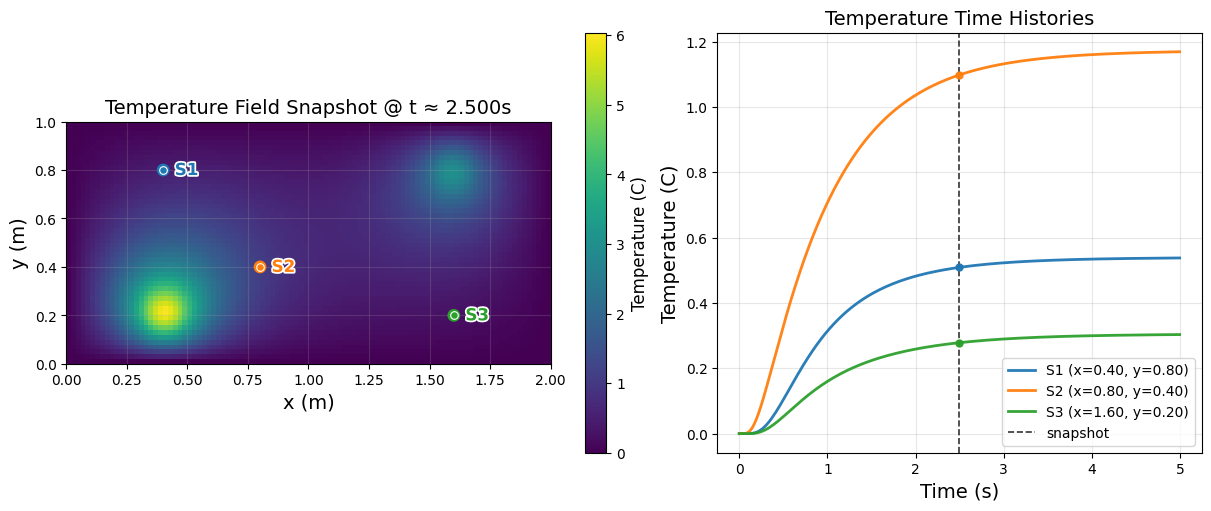

In [4]:
# --- Plotting Configuration from your preferences ---
sensor_labels = ["S1", "S2", "S3"]  # Labels for sensors
sensor_radius: float = 0.02 * min(Lx, Ly)  # plot radius for the circle marker
field_cmap: str = "viridis"  # Colormap for the field ("viridis" or "cividis")

figsize = (12, 5)
title_left = "Temperature Field Snapshot"
title_right = "Temperature Time Histories"
# ----------------------------------------------------

# -------------------------------
# Define consistent colors per sensor
# -------------------------------
# Use tab10 as the base palette; repeat if sensors > 10
base_colors = plt.cm.tab10(np.linspace(0, 1, 10))
num_sensors = (
    sensor_xy.shape[0] if isinstance(sensor_xy, np.ndarray) else len(sensor_xy)
)
sensor_colors = [base_colors[i % len(base_colors)] for i in range(num_sensors)]


# Utility to get label safely
def get_sensor_label(i):
    return sensor_labels[i] if i < len(sensor_labels) else f"S{i+1}"


# --- Select Snapshot for Field Plot ---
if len(times) > 0:
    time_diff = np.abs(times - field_plot_timestamp)
    plot_index = np.argmin(time_diff)
    U_plot = Us_all[plot_index]
    T_plot_actual = times[plot_index]
    print(
        f"Plotting field at time t = {T_plot_actual:.4f}s (closest to requested {field_plot_timestamp:.4f}s)"
    )
else:
    U_plot = Us_all[0]
    T_plot_actual = times[0]
    print("Warning: No time steps stored, plotting initial condition.")

# Use a consistent color range over the whole simulation for the colorbar
vmin = np.min(Us_all)
vmax = np.max(Us_all)
norm = Normalize(vmin=vmin, vmax=vmax)

# ===========================
# Build the figure: 1 row x 2 cols (left, right)
# ===========================
fig, axs = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)

# ----------------------------------------------------------------------
# Left Plot: Temperature Field Snapshot
# ----------------------------------------------------------------------
ax0 = axs[0]

im = ax0.imshow(
    U_plot.T,  # transpose so x is horizontal, y is vertical
    extent=[0, Lx, 0, Ly],
    origin="lower",  # This aligns y=0 with the bottom of the plot
    cmap=field_cmap,
    norm=norm,  # Use normalized color scale
    interpolation="nearest",  # Use nearest for crisp cell boundaries
    aspect="equal",
)
cb = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)
cb.set_label("Temperature (C)", fontsize=12)  # Set colorbar label font size

# Overlay sensor markers (colored circles) + centers + labels
for i, (sx, sy) in enumerate(sensor_xy):
    col = sensor_colors[i]
    lab = get_sensor_label(i)

    # Outer circle (colored edge)
    circ = Circle(
        (sx, sy),
        radius=sensor_radius,
        edgecolor=col,
        facecolor="none",
        linewidth=2.2,
        zorder=3,
    )
    ax0.add_patch(circ)

    # Center dot (filled with same color, thin white edge for visibility)
    ax0.plot(
        sx,
        sy,
        "o",
        markerfacecolor=col,
        markeredgecolor="white",
        markeredgewidth=0.8,
        markersize=5.5,
        zorder=4,
    )

    # Label text (use same color; white outline improves contrast on dark fields)
    txt = ax0.text(
        sx,
        sy,
        f"  {lab}",
        color=col,
        fontsize=12,
        ha="left",
        va="center",
        weight="bold",
        zorder=5,
    )
    # Optional: add a light path effect for legibility on bright backgrounds
    try:
        from matplotlib.patheffects import withStroke

        txt.set_path_effects([withStroke(linewidth=2.5, foreground="white")])
    except Exception:
        pass

ax0.set_title(f"{title_left} @ t ≈ {field_plot_timestamp:.3f}s", fontsize=14)
ax0.set_xlabel("x (m)", fontsize=14)
ax0.set_ylabel("y (m)", fontsize=14)
ax0.set_xlim(0, Lx)
ax0.set_ylim(0, Ly)
ax0.grid(alpha=0.2)  # Light grid

# ----------------------------------------------------------------------
# Right Plot: Temperature Time History
# ----------------------------------------------------------------------
ax1 = axs[1]

# Plot each sensor's history using the SAME color as its marker on the left
for i in range(sensor_history.shape[1]):
    col = sensor_colors[i]
    lab = get_sensor_label(i)
    ax1.plot(
        times,
        sensor_history[:, i],
        label=f"{lab} (x={sensor_xy[i,0]:.2f}, y={sensor_xy[i,1]:.2f})",
        linewidth=2.0,
        alpha=0.95,
        color=col,
    )

# Mark the snapshot time on histories
ax1.axvline(
    T_plot_actual, color="k", linestyle="--", linewidth=1.2, alpha=0.8, label="snapshot"
)

# Mark per-sensor values at the snapshot using the same per-sensor colors
sensor_values_at_snapshot = sensor_history[plot_index, :]
for i, val in enumerate(sensor_values_at_snapshot):
    ax1.plot(T_plot_actual, val, "o", color=sensor_colors[i], ms=5, alpha=0.95)

ax1.set_title(title_right, fontsize=14)
ax1.set_xlabel("Time (s)", fontsize=14)
ax1.set_ylabel("Temperature (C)", fontsize=14)
ax1.legend(fontsize=10)  # Smaller legend font
ax1.grid(True, alpha=0.3)  # Lighter grid

# Optional: tighten y-limits slightly around the data
ymin, ymax = np.min(sensor_history), np.max(sensor_history)
pad = 0.05 * (ymax - ymin + 1e-12)
ax1.set_ylim(ymin - pad, ymax + pad)

plt.show()

---
## 🧪 Data and Synthetic Dataset Generation

For this challenge, we are **not providing a pre-built training dataset**. Instead, you have full access to the `Heat2D` simulation engine, which allows you to **generate your own synthetic data** tailored to your approach. This flexibility is intentional—your solution should leverage the simulator intelligently, both for data generation and during inference.

To help you get started, we provide a **helper pipeline** via the `make_training_dataset()` function in `utils.py`. This function automates the creation of a synthetic dataset for heat source estimation, simulating temperature measurements from multiple sensors in response to heat sources within a 2D thermal plate governed by the heat equation.

---

### ⚙️ Simulation Setup in the Pipeline
The dataset generation pipeline uses the following configuration:
- **Domain size**: $L_x = 2.0$, $L_y = 1.0$
- **Grid resolution**: `nx = 100`, `ny = 50`
- **Thermal diffusivity**: sampled from a distribution (e.g., `{0.05: 0.5, 0.1: 0.5}`)
- **Boundary condition**: Dirichlet or Neumann (fixed or randomly chosen)
- **Initial temperature**: `T0` can be fixed or sampled from a range
- **Source spread**: handled internally by the solver using Gaussian profiles

---

### 📦 Dataset Configuration
- **Number of samples**: `num_samples` (e.g., 50)
- **Time step**: `dt` (e.g., 0.004)
- **Number of time steps**: sampled from a distribution (e.g., `{800: 0.5, 1200: 0.5}`)
- **Source intensity range**: `q_range = (0.5, 2.0)`
- **Source activation window**: automatically set to `(0.0, nt * dt)` for each sample
- **Sensor noise level**: sampled from a distribution (e.g., `{0.0: 0.5, 0.1: 0.5}`)
    - Gaussian noise is added to each sensor reading with zero mean and standard deviation `noise_std`
- **Source/sensor configurations**:  
  Defined by a distribution `num_sources_sensors`, where keys are tuples `(n_sources, n_sensors)` and values are fractions of total samples.  
  Example:  
  ```python
  num_sources_sensors = {
      (1, 8): 0.4,   # 40% of samples have 1 source and 8 sensors
      (2, 10): 0.6   # 60% have 2 sources and 10 sensors
  }

    

### ✅ Important Notes:

- **Design Your Own Pipeline**  
  You are free to create a custom data generation pipeline using the simulator. The flexibility is intentional—tailor your dataset to your approach.

- **Helper Function Is Just a Starting Point**  
  The provided `make_training_dataset()` function is meant to help you get started quickly. Feel free to modify it or build entirely new logic that suits your strategy.

- **Vary Parameters for Robustness**  
  Consider experimenting with different configurations—number of sources, sensor placements, thermal properties, and noise levels—to make your training set diverse and realistic.

- **Use the Simulator Creatively**  
  The simulator is your most powerful tool. Don’t just use it for generating data—integrate it into your inference pipeline for smart parameter optimization and adaptive learning (we will talk more about this later in the starter notebook: Make sure to read till the end of this notebook).



### 📦 Example Dataset Generation and Structure

The following cell generates an **example dataset with 5 samples** using the provided `make_training_dataset()` pipeline. This is just a demonstration—participants are free to create larger or custom datasets using the simulator.

---

#### ✅ Structure of the Generated Dataset
The dataset is a **dictionary** with two main keys:

- **`samples`**  
  A list where each element corresponds to one sample and contains:
  - `sample_id`: Unique identifier for the sample.
  - `n_sources`: Number of heat sources in this sample.
  - `true_sources`: A list of dictionaries, each describing a source with:
    - `x`, `y`: Source location.
    - `q`: Source intensity.
    - `on`: Activation window (start and end time).  
      **Note:** In all simulations, the activation window is from time zero to the end of the run, so you can **ignore this field**. You only need to predict **location (`x`, `y`) and intensity (`q`)** for each source.
  - `sensors_xy`: Array of sensor coordinates.
  - `Y`: Sensor readings **without noise** (shape: time steps × number of sensors).
  - `Y_noisy`: Sensor readings **with noise** added.
  - `sample_metadata`: Metadata specific to this sample:
    - `noise_std`: Standard deviation of sensor noise.
    - `nt`: Total number of simulation steps.
    - `kappa`: Thermal diffusivity.
    - `bc`: Boundary condition type.
    - `T0`: Initial temperature.

- **`meta`**  
  Metadata common to all samples, such as:
  - `q_range`: Range of source intensities used.
  - `dt`: Time step for the simulation.

---

This structure provides everything you need for training and evaluation: sensor readings, ground-truth source parameters, and simulation settings.


In [5]:
Lx, Ly = 2.0, 1.0
nx, ny = 100, 50
dt = 0.004

num_samples = 5
num_sources_sensors = {(1, 3): 0.2, (1, 4): 0.2, (2, 5): 0.6}
noise_std = {0.0: 0.5, 0.1: 0.5}
nt = {800: 0.6, 1000: 0.2, 1200: 0.2}
kappa = {0.05: 0.5, 0.1: 0.5}
bc = "random"
T0 = None
q_range = (0.5, 2)

In [6]:
dset = make_training_dataset(
    Lx,
    Ly,
    nx,
    ny,
    num_samples,
    dt,
    num_sources_sensors,
    q_range,
    noise_std,
    nt,
    kappa,
    bc,
    T0,
    seed=0,
)

In [7]:
dset

{'samples': [{'sample_id': 'sample_0',
   'n_sources': 1,
   'true_sources': [{'x': 1.152497410863195,
     'y': 0.07993887673425679,
     'q': 1.3400148985677316,
     'on': (0.0, 4.8)}],
   'sensors_xy': array([[1.15249741, 0.25067479],
          [0.15987775, 0.70688676],
          [1.10801788, 0.24516745]]),
   'Y': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [2.78833890e-03, 2.67274915e-41, 2.43333919e-03],
          [8.33477242e-03, 3.31990020e-38, 7.50069632e-03],
          ...,
          [6.73958136e+00, 1.45247692e+00, 6.72243267e+00],
          [6.74235468e+00, 1.45466682e+00, 6.72518258e+00],
          [6.74512764e+00, 1.45685730e+00, 6.72793215e+00]], shape=(1201, 3)),
   'Y_noisy': array([[-0.08876115,  0.16825662, -0.05907138],
          [-0.08422805, -0.09852882,  0.13550326],
          [-0.11601175,  0.14240399,  0.022122  ],
          ...,
          [ 6.64948158,  1.46167972,  6.79513607],
          [ 6.57164027,  1.42540934,  6.76845591],
       



### Visualize Sensor Layout and Temperature Histories

The `plot_sensor_temp()` function from **`utils.py`** lets you quickly visualize sensor positions, true source locations, and the corresponding temperature time histories for selected samples. This is a helpful way to understand the spatial setup and data structure before building your models.

In the example below, we plot **`sample_4`** from the sample dataset `dset`.  
- **Dashed lines** represent clean sensor readings (`Y`), while  
- **Solid lines** represent noisy readings (`Y_noisy`).  

Note: Sensors are subject to Gaussian noise with varying standard deviations across samples (including zero). In some cases, there is no noise, so `Y` = `Y_noisy`.  
As we’ll explain in the next section, the **test dataset** will only include noisy readings (`Y_noisy`)—clean readings (`Y`) will not be available.



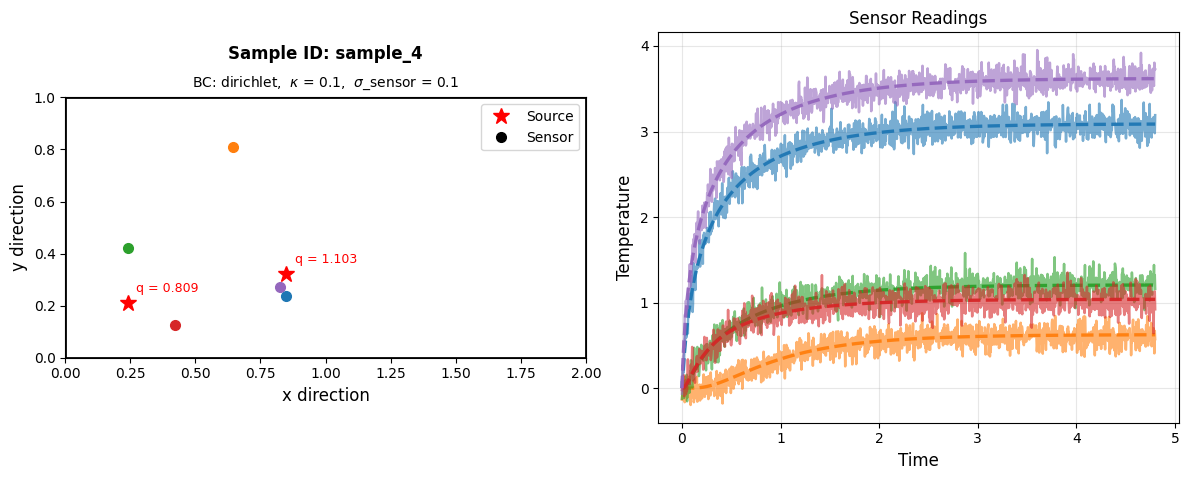

In [8]:
plot_sensor_temp(dataset=dset, sample_ids=["sample_4"])

---
## 🧼 Preparing the Test Dataset by Removing Ground Truth Sources and Clean Sensor Readings

In this step, we use the `remove_source_parameters()` utility to **strip out the ground-truth information** from each sample. Specifically, this function removes:
- `"true_sources"`: The actual source parameters (location, intensity, activation window).
- `"Y"`: The clean sensor readings without noise.

By doing this, we convert the dataset into a **test-ready format** (`test_dset`) that contains:
- No source parameter information (so predictions can be evaluated fairly).
- No clean sensor readings (only noisy readings remain).
- All relevant metadata for simulation context.

This ensures the dataset is suitable for **evaluating your source estimation models** without exposing the answers.

---

### ✅ About the Provided Test Dataset
The official **test dataset** (`testdataset_80samples.pkl`) you have been provided follows **exactly the same format** as this modified dataset. It contains:
- **80 samples** prepared for evaluation.
- Stored in **pickled format** (`.pkl` file).

To load the test dataset in your notebook, use:

```python
import pickle

with open("testdataset_80samples.pkl", "rb") as f:
    test_dset = pickle.load(f)


In [9]:
test_dset = remove_source_parameters(dset)

In [10]:
test_dset

{'samples': [{'sample_id': 'sample_0',
   'n_sources': 1,
   'sensors_xy': array([[1.15249741, 0.25067479],
          [0.15987775, 0.70688676],
          [1.10801788, 0.24516745]]),
   'Y_noisy': array([[-0.08876115,  0.16825662, -0.05907138],
          [-0.08422805, -0.09852882,  0.13550326],
          [-0.11601175,  0.14240399,  0.022122  ],
          ...,
          [ 6.64948158,  1.46167972,  6.79513607],
          [ 6.57164027,  1.42540934,  6.76845591],
          [ 6.63140598,  1.47242617,  6.74522035]], shape=(1201, 3)),
   'sample_metadata': {'noise_std': 0.1,
    'nt': 1200,
    'kappa': 0.1,
    'bc': 'neumann',
    'T0': 0.0}},
  {'sample_id': 'sample_1',
   'n_sources': 1,
   'sensors_xy': array([[0.9030097 , 0.13421833],
          [0.93069597, 0.63192601],
          [0.22899659, 0.54307281],
          [1.58241563, 0.72296319]]),
   'Y_noisy': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [4.63096924e-09, 9.12748584e-04, 1.37004212e-22, 3


---

## 📤 Submission Format: How to Structure Your Predictions

Before diving into evaluation metrics and objectives, let’s clarify the **general objective** and how your submission should look.

### 🎯 General Objective
For the predictive leaderboard, your goal is to **estimate the heat source parameters**—their **locations (`x`, `y`) and intensities (`q`)**—for each sample in the test dataset. These estimated sources should produce sensor readings as close as possible to the ground-truth readings.

---

### ✅ Key Rules
- For each sample, you **know the number of sources** (`n_sources`) from the test dataset.
- For each source, predict **(x, y, q)**.
- Each set of predictions for a sample is called a **candidate**.
- You can provide **up to `N_max = 3` candidates per sample**:
  - Minimum: 1 candidate.
  - Maximum: 3 candidates.
- **Why multiple candidates?**  
  Because there may be more than one valid source configuration that explains the observed sensor readings. Later in the evaluation metric section, we’ll explain why including up to three high-quality candidate solutions—when they genuinely exist—can improve your score. However, adding extra candidates that are not good will negatively impact your score, so only include additional candidates if they are strong and relevant.
---

### 📦 Prediction Structure
Your predictions should be organized as a **list of dictionaries**, where:
- Each dictionary corresponds to one sample.
- Each dictionary has two keys:
  - `"sample_id"`: Matches the sample ID in the test dataset.
  - `"estimated_sources"`: A list of candidate configurations.  
    Each candidate is itself a list of tuples `(x_i, y_i, q_i)` for all sources in that sample.

Example structure:

```python
estimated_source_dataset = [
  {
    "sample_id": "sample_0",
    "estimated_sources": [
        [ (x1, y1, q1) ],                      # Candidate 1 (for 1-source sample)
        [ (x1, y1, q1) ]                       # Candidate 2
    ]
  },
  {
    "sample_id": "sample_1",
    "estimated_sources": [
        [ (x1, y1, q1), (x2, y2, q2) ],       # Candidate 1 (for 2-source sample)
        [ (x1, y1, q1), (x2, y2, q2) ],       # Candidate 2
        [ (x1, y1, q1), (x2, y2, q2) ]        # Candidate 3
    ]
  },
  ...
]
```

### 📁 Submission File Format

Once your predictions are ready:

1.  Wrap the list in a dictionary (key must be the string `samples`) as:
    `submission = {'samples': estimated_source_dataset}`
2.  Save as an **.npz** file:

    ```python
    import numpy as np
    np.savez('submission_filename.npz', **submission)
    ```

This **.npz** file is what you will upload for the predictive leaderboard evaluation.

---

### 🔍 Dummy Submission Example

To help you understand the structure, we provide a helper function `dummy_source_estimator()` that generates random source candidates for each sample in the test dataset. This is purely for demonstration and testing the evaluation pipeline.

### ⚙️ Function Purpose

* Creates a mock submission file with random estimates.
* Each sample gets between 1 and $ N_{max}$ candidates.

### ✅ Parameters

* `dataset`: The test dataset.
* `Lx, Ly`: Domain dimensions for random source placement (they always have fixed values of 2.0 and 1.0, respectively, across all samples, even for the final evaluation).
* `q_range`: Range for random source intensity.
* `N_max`: Maximum number of candidates per sample.
* `number_candidates`: `"random"` or `"fixed"`:
    * `"random"` → Random number of candidates between 1 and $N_{max}$.
    * `"fixed"` → Always $N_{max}$ candidates.

### 📦 Output Structure

The function returns a **list of dictionaries** in the exact format required for submission.

---

In the next cell, we'll use `dummy_source_estimator()` to generate a sample submission for the example test dataset above (with 5 samples) and inspect its structure.


In [11]:
N_max = 3
estimated_source_dataset = dummy_source_estimator(
    test_dset, Lx, Ly, q_range, N_max, number_candidates="fixed"
)

In [12]:
estimated_source_dataset

[{'sample_id': 'sample_0',
  'estimated_sources': [[(1.6170258887906803,
     0.891478339592373,
     0.8716107301710394)],
   [(0.6077042156877341, 0.2866070727276543, 1.601922239887303)],
   [(1.5876804806778908, 0.27907548141413663, 1.6019174973235117)]]},
 {'sample_id': 'sample_1',
  'estimated_sources': [[(0.836663623718223,
     0.7424520737367087,
     0.5467995722251782)],
   [(0.5419866252087762, 0.2942214140742674, 1.6066665817759314)],
   [(0.07168266853494165, 0.9030962760732106, 1.98600394968454)]]},
 {'sample_id': 'sample_2',
  'estimated_sources': [[(0.548835196574782,
     0.6777723431198889,
     1.1064135337468772),
    (0.06505865261633725, 0.6871705357467153, 1.9009956527563538)],
   [(0.21436411644343667, 0.22134962612528097, 1.7272705766357368),
    (1.282963126637551, 0.5807001173641586, 1.3176100668439816)],
   [(1.8904836277552375, 0.06377732447396389, 1.4266602717488939),
    (0.0812764549970868, 0.37601869516996467, 1.5228279057107585)]]},
 {'sample_id': 'sam

In [13]:
submission = {"samples": estimated_source_dataset}
np.savez("submission_random_estimator.npz", **submission)


### Compare Ground-Truth vs Estimated Sources

Having estimated sources, the `plot_gt_vs_est()` function (from **`utils.py`**) can help you visually assess how close your estimated source candidates are to the ground truth for selected samples.

**What it shows:**
- **Left subplot:**  
  - Thermal plate with sensor positions (colored circles).  
  - Ground-truth sources (red stars) and all estimated candidates (colored stars), annotated with their intensities `q`.  
  - Metadata such as boundary condition (BC), thermal diffusivity (κ), and noise level (σ).

- **Right subplot:**  
  - Clean sensor readings (`Y`) for the ground-truth sources (solid lines).  
  - Overlaid simulated readings for one or more estimated candidates (dashed/dotted lines), using consistent sensor colors.  
  - This lets you visually compare how well your candidate reproduces the true sensor signals.


**Example below:** 

For the sample dataset created earlier (`dset`) and the estimates generated using the random estimator (`estimated_source_dataset`), we compare the ground truth with Candidate #2 for `sample_1`.


**IMPORTANT NOTE:**  
Sometimes an estimated source candidate may not closely match the ground truth in terms of location or intensity, yet still produce sensor readings that align very well with the observed data—which is what ultimately matters.

Why? For a given set of sensor readings, there can be multiple source configurations that yield the same (or sufficiently similar) readings. All such configurations are equally valid.

This is why we allow **multiple candidates per sample (up to 3)**: as long as they reproduce the observed sensor readings, they are considered equivalent.  
**Moreover, if more than one distinct candidate achieves this, submitting all of them will result in a better evaluation score than submitting only one.** For example, if two sufficiently different configurations produce equally accurate sensor readings, including both will improve your score for that sample.

This serves as a natural segue into the next section, where we explain how the performance metric is defined and how your submissions will be numerically evaluated.



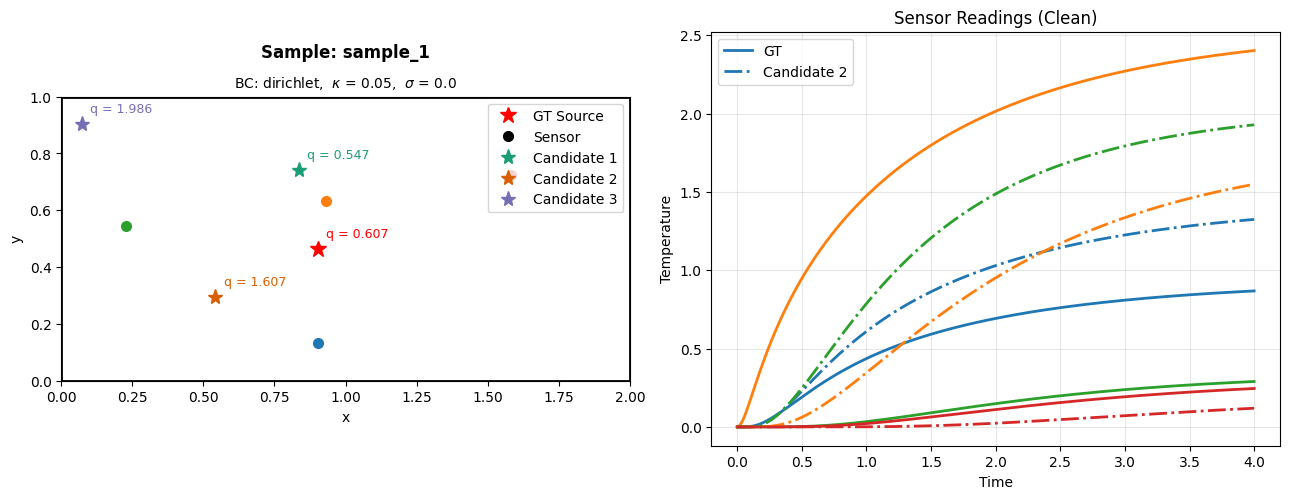

In [14]:
solver_kwargs = {"Lx": Lx, "Ly": Ly, "nx": nx, "ny": ny}

plot_gt_vs_est(
    dset,
    estimated_source_dataset,
    ["sample_1"],
    solver_kwargs=solver_kwargs,
    candidates_to_plot=[2],
)


## 📊 Performance Metric for Leaderboard Evaluation

Now that you understand how to structure your source predictions and format your submission file, let’s explore the details of how your leaderboard score is calculated. The leaderboard score is based on how well your predicted source parameters reproduce the observed sensor readings and how diverse your candidate solutions are. We use a **composite metric** that combines **accuracy** and **diversity**.

- **Accuracy**: Measures how well the estimated sources reproduce the ground-truth sensor temperature profiles using a forward loss function ($L$).
- **Diversity**: Rewards submissions that provide multiple distinct source candidates per sample (up to a maximum of $N_{\text{max}}$), while filtering out trivial perturbations.

---

### 🧮 Composite Performance Metric

We define a composite metric that incorporates both elements and it is calculated as explained below.

#### **Step 1: Definitions**
For each sample, let's define the list of source candidates,$\mathcal{C}$, as:

$$
\mathcal{C} = [ C_1, C_2, \dots, C_N ]
$$

- $N = |\mathcal{C}|$: number of source candidates.
- $L_i$: forward loss for candidate $C_i$, measuring how well it reproduces sensor readings.
- $D(C_i, C_j)$: dissimilarity metric between two candidates.
- $\tau$: dissimilarity threshold (to ensure distinctness). Only candidates satisfying \$D(C_i, C_j) > \tau\$ for all \$i \neq j\$ are considered distinct.
- $N_{\text{valid}}$: number of source candidates that pass the dissimilarity test (i.e., truly distinct). 

---

#### **Step 2: Dissimilarity Filtering**

To prevent trivial variations:

- For each pair \$(C_i, C_j)\$, compute \$D(C_i, C_j)\$.  
- Define \$D\$ as a normalized distance metric over source parameters (in our case, Euclidean distance over location and intensity vectors).  
- Only include candidates in \$\mathcal{C}\$ if all pairwise distances exceed \$\tau\$.  
- Cap \$N_{\text{valid}} \leq N_{\text{max}}\$.


---

#### **Step 3: Composite Score**
We define the performance score \$P\$ for a sample as:

$$
P = \frac{1}{N_{\text{valid}}} \sum_{i=1}^{N_{\text{valid}}} \left( \frac{1}{1 + L_i} \right) + \lambda \cdot \frac{N_{\text{valid}}}{N_{\text{max}}}
$$

Where:

- The first term rewards low forward loss (higher is better).  
- The second term rewards diversity (more valid solutions).  
- \$\lambda\$ is a tunable weight to balance accuracy vs. diversity.

**Note:**  The forward loss quantifies the mismatch between the ground-truth clean sensor readings and those simulated from an estimated source candidate. This misfit is computed as the **root-mean-square error (RMSE)** across all time steps and sensors for a given sample. The calculation is implemented in the `forward_error()` function provided in the `utils.py` module.

---

#### **Step 4: Aggregation Across Samples**


For a submission with $M$ samples, the final predictive learderboard score is calculated as:

$$
\text{Final Score} = \frac{1}{M} \sum_{j=1}^{M} P_j
$$

Where \$P_j\$ is the score for sample \$j\$.

---



### Details of Dissimilarity Filtering

In this section, we discuss why dissimilarity filtering is necessary, outline its key challenges, and then walk through the step-by-step process of how it is applied. Reading this section is **optional** but a good understanding of its concept will help you design a better prediction pipeline.

---
#### ■ Key Challenges

- **Permutation Invariance**: Two source candidates with the same source tuples in different orders should be considered identical.  
- **Trivial Perturbations**: Slight modifications to a source candidate should not count as a distinct solution.  
- **Efficient Filtering**: We need a method to filter out near-duplicates efficiently.
---

#### ■ Definitions
Before diving into the filtering algorithm, let’s define the following:

- For a given sample, the number of sources is fixed: \$K\$.  
- Each source tuple \$s\$ is a vector of parameters (i.e., location, intensity):  
  $$
  s = (x, y, q) \in \mathbb{R}^3
  $$
- A source candidate \$C\$ is a list of \$K\$ source tuples:  
  $$
  C = [s_1, s_2, \dots, s_K]
  $$
- The estimated source candidate list for a sample is:  
  $$
  \mathcal{C} = [ C_1, C_2, \dots, C_N ]
  $$
  where \$N \leq N_{\text{max}}\$.

---


### ■ Step-by-Step Filtering Algorithm

#### Step 1: Normalize Source Candidates

To handle permutation invariance:

- For each source candidate \$C_i\$, sort the source tuples by a deterministic rule (e.g., lexicographic order of their parameter vectors).  
- This ensures that \$[s_1, s_2]\$ and \$[s_2, s_1]\$ are treated identically.

Let:

$$
\tilde{C}_i = \text{sort}(C_i)
$$



#### Step 2: Define a Dissimilarity Metric

Define a distance between two source candidates \$\tilde{C}_i\$ and \$\tilde{C}_j\$ as:

$$
D(\tilde{C}_i, \tilde{C}_j) = \frac{1}{K} \sum_{k=1}^{K} \| s_k^{(i)} - s_k^{(j)} \|_2
$$

This is the average Euclidean distance between corresponding source tuples in the sorted candidates.


#### Step 3: Filtering Procedure

Given a dissimilarity threshold $\tau$:

- Initialize an empty list: $\mathcal{C}_{\text{valid}} = []$

- For each $\tilde{C}_i \in \mathcal{C}$: If $\forall \tilde{C}_j \in \mathcal{C}_{\text{valid}}, \; D(\tilde{C}_i, \tilde{C}_j) > \tau$ then: Add $\tilde{C}_i$ to \$\mathcal{C}_{\text{valid}}$.

- Stop if $|\mathcal{C}_{\text{valid}}| = N_{\text{max}}$

Return $\mathcal{C}_{\text{valid}}$ as the filtered list of distinct source candidates.


#### ✅ Demonstrating Score Calculation

Now that we’ve explained the performance metric and filtering logic in detail, this cell **demonstrates how your submission score is computed** using the provided `score_submission()` function.

We use:
- The example test dataset generated earlier.
- The dummy predictions created with `dummy_source_estimator()`.

The function `score_submission()` (and related utilities like `filter_distinct_candidates()`) are all available in `utils.py`. Feel free to explore these functions to understand exactly how:
- Forward loss is calculated.
- Candidate filtering and distinctness checks are implemented.
- The composite score is aggregated across samples.

This is the same process (with the same parameter values, such as $\lambda$ and $\tau$) that will be applied to your submission on the leaderboard.


In [15]:
lambda_ = 0.3
tau = 0.2
scale_factors = (Lx, Ly, q_range[1])
forward_loss = "rmse"

solver_kwargs = {"Lx": Lx, "Ly": Ly, "nx": nx, "ny": ny}

gt_dataset = dset.copy()


submission_npz = dict(np.load("submission_random_estimator.npz", allow_pickle=True))
submission_npz["samples"] = list(submission_npz["samples"])
pred_dataset = submission_npz["samples"]

# Or alternatively you can just do: pred_dataset = estimated_source_dataset.copy()

In [16]:
start = time.time()
final_score = score_submission(
    gt_dataset,
    pred_dataset,
    N_max,
    lambda_,
    tau,
    scale_factors,
    forward_loss,
    solver_kwargs,
)
end = time.time()
print("\n Final Submission Score:", round(final_score, 6))
print(f"\n Execution time: {end - start:.2f} seconds")

Calculating score for sample ID: sample_0...
	 - number of valid candidates for this sample: 3
Calculating score for sample ID: sample_1...
	 - number of valid candidates for this sample: 3
Calculating score for sample ID: sample_2...
	 - number of valid candidates for this sample: 3
Calculating score for sample ID: sample_3...
	 - number of valid candidates for this sample: 3
Calculating score for sample ID: sample_4...
	 - number of valid candidates for this sample: 3

 Final Submission Score: 0.635039

 Execution time: 19.63 seconds


---
.
# 🎯 Challenge Objectives and Final Evaluation Criteria <span style="color:red;">(Please Read Carefully – Important!)</span>
This challenge is not just about achieving the highest predictive leaderboard score—it’s about developing **smart, generalizable methods** for simulation-driven parameter optimization. Below we outline the objectives, evaluation process, and what we expect from participants.

---

### ✅ Core Objective
Your goal is to design a solution that:
- **Estimates heat source parameters** (location `x`, `y` and intensity `q`) for each sample in the test dataset.
- Produces sensor readings as close as possible to the ground truth.
- **Leverages the provided simulation engine intelligently during inference**, not just for generating training data.

---

### ⚠️ Important Rules
- **Use of the simulation engine at inference time is mandatory.**
- **Brute-force grid search** and **pure end-to-end ML inference without simulation feedback** are **not allowed**.
- Submissions that violate these rules will be **discarded** during the final evaluation, even if they rank first on the predictive leaderboard.

Why? Because the challenge is designed to encourage **adaptive, physics-informed optimization strategies**, not memorization or exhaustive search.

---

### 🏆 Final Evaluation Process
While the predictive leaderboard score is based on your submitted predictions for the provided test dataset, the **final winners** will be determined after:
1. **Code Submission**: Top scorers will be asked to submit their full code.
2. **Reproducibility Check**: Our panel will run your code and verify results.
3. **Holdout Dataset Evaluation**: Your solution will be tested on a completely unseen dataset. Please note that the holdout dataset is much bigger and more diverse than the test dataset.
4. **Innovation Assessment**: Judges will review your approach for creativity and effective use of the simulator.

The **final score** will be computed as:
- **70%**: Performance on the holdout dataset.
- **20%**: Innovation and efficacy of simulation use at inference.
- **10%**: Documentation quality and interpretability.

---

### ✅ What We’re Looking For
For the **20% innovation score**, we assess:
- **Integration of Simulator in Inference**  
  Does your method actively use the simulator during parameter estimation, rather than only for pre-training?
- **Optimization Strategy**  
  Is your approach smarter than brute-force? Examples include:
  - Bayesian Optimization with simulation-in-the-loop.
  - Reinforcement Learning (RL) for adaptive parameter tuning.
  - Meta-learning strategies that learn how to search efficiently.
  - Gradient-based refinement using differentiable or surrogate models.
- **Learning at Inference**  
  Does your method adapt based on prior experience (e.g., transfer learning, surrogate modeling)?
- **Inference Speed**  
  How quickly does your pipeline converge to a solution during the inference? How many complete/incomplete calls does it make to the simulator?
- **Generality and Scalability**  
  Could your approach generalize to other simulation-driven problems beyond heat diffusion?
- **Documentation of Innovation**  
  Clear explanation of how the simulator is used and why your approach is innovative.

---

### ❌ What Will Be Discarded
- **Brute-force grid search** solutions.
- **Pure end-to-end ML inference** that does not use the simulator during inference.
- Hardcoded or non-generalizable solutions.

---

### 💡 Example Approaches We Encourage
- **Bayesian Optimization**  
  Iteratively propose source parameters using an acquisition function, evaluate via simulation, and update a surrogate model.
- **Reinforcement Learning (RL)**  
  Treat parameter tuning as a sequential decision-making problem, using the simulator as the environment.
- **Meta-Learning**  
  Train a model that learns how to optimize efficiently across multiple samples.
- **Hybrid Physics-Informed ML**  
  Combine machine learning with physics constraints and simulation feedback for refinement.
- **Differentiable Simulation or Surrogate Models**  
  Use gradients or approximations to guide parameter updates.

---

### ✅ Key Takeaways
- The simulator is **not just a data generator**—it **MUST** be an active component of your inference pipeline.
- Innovation matters: even if your predictive leaderboard score is high, failure to follow these guidelines will result in disqualification.
- Document your approach clearly: explain how you use the simulator and why your method is efficient and generalizable.

---

**In short:**  
This challenge is about building **smart, adaptive, and physics-informed (simulation-assisted) solutions** that go beyond brute force and memorization. Show us your creativity and technical depth! <b>Thank you for your attention to details and good luck with the challenge!</b>
